In [25]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [26]:
# Analyze reliability, bandwidth, energy
data = []
deadcols = np.genfromtxt("../settings/dead_columns.csv", delimiter=",")
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_go_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_go_{att}.csv", delimiter=',')
        except OSError:
          continue
        try:
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_go_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_go_{att}.csv", delimiter=',')
        except OSError:
          ivdd = np.array([0])
          ivddio = np.array([0])

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_go_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_go_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                for i in range(65535):
                    for j in range(48):
                        if (j in deadcols):
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_go_{att}.csv", confmat, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data

1bpc_pba_1165
1bpc_bwa_0
1bpc_bwa_1
2bpc_bwa_1166
2bpc_bwa_1408
2bpc_bwa_2575
2bpc_bwa_2891
2bpc_bwa_2226
2bpc_bwa_1935
2bpc_bwa_1508
2bpc_bwa_1431


,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_bwa_0_cb,1,1,0.0565946102142334,0.056362,0.000000,0.000000e+00,0.000000e+00,4.883598e+07,0.063102,...,0.251202,65536,2750049,327680,65536,65536,5636152,4128768,1373842,1376207
1,1bpc_bwa_0_cb,2,1,0.08516287803649902,0.084933,0.000000,0.000000e+00,0.000000e+00,3.240772e+07,0.016514,...,0.128505,65536,161576,458749,65678,117853,8493254,8526824,1371717,1536777
2,1bpc_bwa_0_cb,4,1,0.09653902053833008,0.096381,0.000000,0.000000e+00,0.000000e+00,2.855817e+07,0.009808,...,0.099033,65536,12282,514999,65707,128710,9638119,9610685,1371921,1521172
3,1bpc_bwa_0_cb,8,1,0.09933328628540039,0.099195,0.000000,0.000000e+00,0.000000e+00,2.774808e+07,0.007453,...,0.086333,65536,3209,527107,65865,135952,9919497,9713184,1372169,1514430
4,1bpc_bwa_0_cb,16,1,0.10078263282775879,0.100650,0.000000,0.000000e+00,0.000000e+00,2.734698e+07,0.006094,...,0.078063,65536,1146,533127,65974,140334,10064987,9744564,1372806,1510012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2bpc_bwa_1431_lfsr,128,2,5.5498058795928955,5.549347,0.004145,4.178274e-09,4.211979e-15,9.919978e+05,0.149458,...,0.631854,65536,92916,14363137,2816069,10561939,554934674,36676167,11110938,15246858
210,2bpc_bwa_1431_lfsr,256,2,9.281028032302856,9.280678,0.004201,7.082094e-09,1.193957e-14,5.931614e+05,0.147833,...,0.628448,65536,85499,23708803,3008644,19703035,928067804,47590466,11283600,25847250
211,2bpc_bwa_1431_lfsr,512,2,16.53011155128479,16.529687,0.004193,1.259062e-08,3.780587e-14,3.330335e+05,0.146593,...,0.625507,65536,82001,41858645,3334903,37515516,1652968669,68597998,11622333,46384754
212,2bpc_bwa_1431_lfsr,1024,2,30.71998691558838,30.719461,0.004275,2.385328e-08,1.331095e-13,1.792004e+05,0.145485,...,0.622822,65536,79955,77373285,3869830,72494434,3071946119,109433963,12136255,86694942


/tmp/ipykernel_233945/2572852257.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale("log")


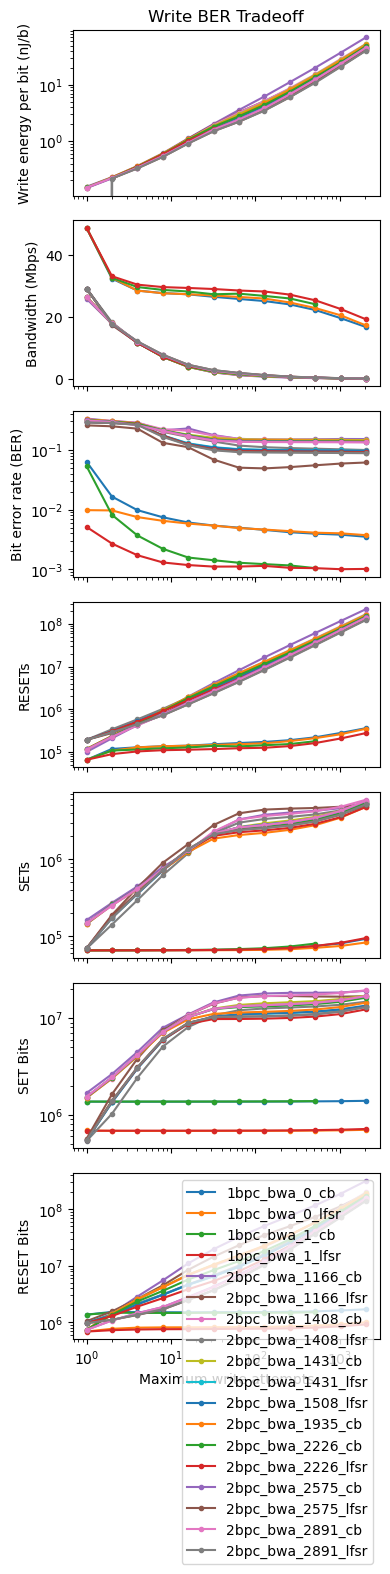

In [27]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  axs[1].set_ylabel("Bandwidth (Mbps)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()